In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import train_test_split, cross_validate

from scipy.stats import pearsonr, chi2_contingency
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. Data

The data for this project comes from Kaggle. Although I wrangle raw data in other projects I wanted to focus on the rest of preprocessing via pipelining. The the data features car evaluation metrics for classification, such as number of doors, safety, and maintenance cost - each bearing a range of 3-5 categorically ordered values like 'unacc', 'acc', 'vgood', and 'good' for the car_class feature.

##### Data Dictionary
* price    overall price
* buying   buying price
* maint    price of the maintenance
* doors    number of doors
* persons  capacity in terms of persons to carry
* lug_boot the size of luggage boot
* safety   estimated safety of the car The dataset is simple with some minor variation amongst feature variations

data source:
https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

### 1.1 Load & Inspect Data

In [3]:
data = pd.read_csv('../Data/car.data')
# 1.1.1 Inspect Table
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   door      1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 712.2 KB


,buying,maint,door,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
shape = data.shape
print(f"The {shape[0]} rows of data have {shape[1]} features. Since this is a classification problem I'll be selecting one to be the target, leaving me with {shape[1]-1} features to work with.\nAt this point it would seem that door and persons are numeric features but I'll check that shortly.")

The 1728 rows of data have 7 features. Since this is a classification problem I'll be selecting one to be the target, leaving me with 6 features to work with.
At this point it would seem that door and persons are numeric features but I'll check that shortly.


In [5]:
#check for dupes
print(len(data[data.duplicated()]))

#check for missing
print(data[data.isnull().any(axis=1)])
print(data.isna().sum())

0
Empty DataFrame
Columns: [buying, maint, door, persons, lug_boot, safety, class]
Index: []
buying      0
maint       0
door        0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


In [6]:
# 1.1.2 Inspect & Modify Columns
data.nunique()


buying      4
maint       4
door        5
persons     3
lug_boot    3
safety      3
class       4
dtype: int64

In [7]:
# 'class' is a problematic name.
data = data.rename({'class': 'car_class'}, axis=1)

In [8]:

for i in data.columns:
    print(i)
    print(data[i].value_counts())
    print(data[i].unique(),'\n')

buying
low      432
vhigh    432
med      432
high     432
Name: buying, dtype: int64
['vhigh' 'high' 'med' 'low'] 

maint
low      432
vhigh    432
med      432
high     432
Name: maint, dtype: int64
['vhigh' 'high' 'med' 'low'] 

door
2        432
4        432
3        432
5more    405
more      27
Name: door, dtype: int64
['2' '3' '4' '5more' 'more'] 

persons
2       576
4       576
more    576
Name: persons, dtype: int64
['2' '4' 'more'] 

lug_boot
small    576
med      576
big      576
Name: lug_boot, dtype: int64
['small' 'med' 'big'] 

safety
low     576
med     576
high    576
Name: safety, dtype: int64
['low' 'med' 'high'] 

car_class
unacc    1210
acc       384
good       69
vgood      65
Name: car_class, dtype: int64
['unacc' 'acc' 'vgood' 'good'] 



While door and persons appear to be numeric variables, they are in fact categorical.

In [9]:
data.door.value_counts()
# note the clearly categorical values.

2        432
4        432
3        432
5more    405
more      27
Name: door, dtype: int64

In [10]:
#strings = ['buying','maint','lug_boot','safety','class']
# nope, they're all categorical and can be converted to string type.
for i in data.columns:
    data[i] = data[i].astype('string')

data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   buying     1728 non-null   string
 1   maint      1728 non-null   string
 2   door       1728 non-null   string
 3   persons    1728 non-null   string
 4   lug_boot   1728 non-null   string
 5   safety     1728 non-null   string
 6   car_class  1728 non-null   string
dtypes: string(7)
memory usage: 712.2 KB


## 2. Initial EDA

### 2.1 Descriptive Stats

In [11]:
data.describe(include='all')

,buying,maint,door,persons,lug_boot,safety,car_class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,5,3,3,3,4
top,high,high,3,more,big,high,unacc
freq,432,432,432,576,576,576,1210


In [12]:
target='car_class'
for i in data.columns:
    print(i)
    feature = pd.crosstab(data[i], data[target])
    # calculate the chi squared statistic and save it as chi2, then print it:
    chi2, pval, dof, expected = chi2_contingency(feature)
    print(chi2)

#TODO Flesh out contingency tables and explain.
#TODO Explain and visualize these scores.

buying
189.24300964187327
maint
142.9405303030303
door
24.82253897288482
persons
371.3367281433981
lug_boot
53.28202539802095
safety
479.3224398131512
car_class
5184.0


### 2.2 Visualizing Data

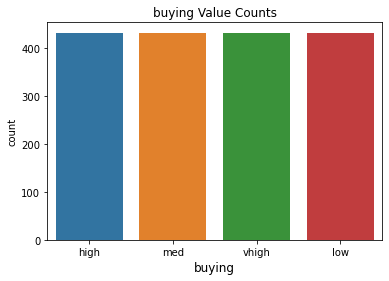

high     432
med      432
vhigh    432
low      432
Name: buying, dtype: Int64


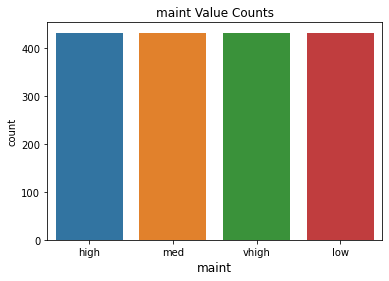

high     432
med      432
vhigh    432
low      432
Name: maint, dtype: Int64


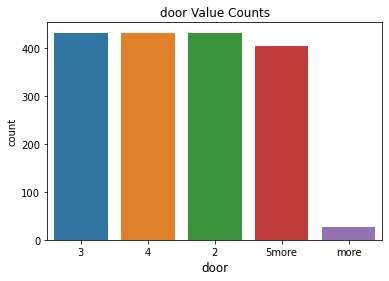

3        432
4        432
2        432
5more    405
more      27
Name: door, dtype: Int64


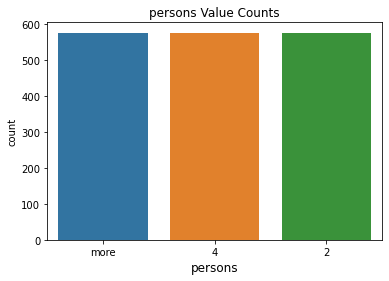

more    576
4       576
2       576
Name: persons, dtype: Int64


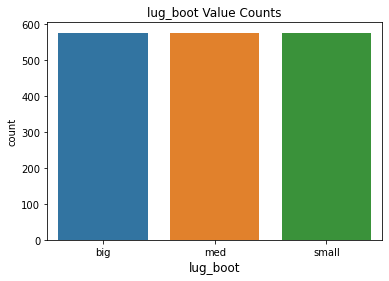

big      576
med      576
small    576
Name: lug_boot, dtype: Int64


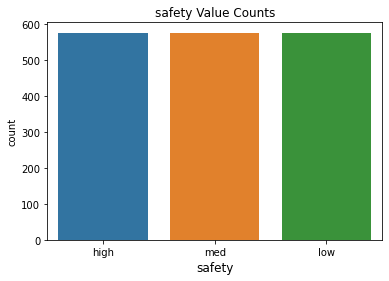

high    576
med     576
low     576
Name: safety, dtype: Int64


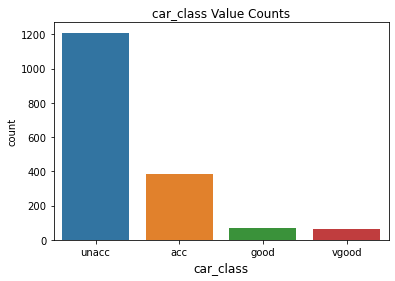

unacc    1210
acc       384
good       69
vgood      65
Name: car_class, dtype: Int64


<Figure size 432x288 with 0 Axes>

In [13]:
for column in data.columns.tolist():
  
  
  sns.countplot(x=data[column],order=data[column].value_counts().index)
  plt.title(column+' Value Counts')
  plt.xticks(rotation=0,fontsize=10)
  plt.xlabel(column,fontsize=12)
  plt.show()
  plt.clf()
  print(data[column].value_counts())

### 2.3 EDA Observations
* buying: 
* maint:
* door:
* persons:
* lug_boot:
* safety:
* car_class:

## 3. Preprocessing

### 3.1 Reinspect Data

In [14]:
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   buying     1728 non-null   string
 1   maint      1728 non-null   string
 2   door       1728 non-null   string
 3   persons    1728 non-null   string
 4   lug_boot   1728 non-null   string
 5   safety     1728 non-null   string
 6   car_class  1728 non-null   string
dtypes: string(7)
memory usage: 712.2 KB


,buying,maint,door,persons,lug_boot,safety,car_class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


### 3.2 Diagnose Data
This data is extremely clean, which is great for a simple project. Although the mostly even splits throughout the data are initially concerning, there doesn't seem to be any significant overlap, at this time.

### 3.3 Data Wrangling
Since I'd like this to remain a simple KNN classifier project I will need to generate a new column for the specific value I'm training the model to find.

## 4. Hyperparameter Tuning & Assessment
Since all my independent features are ordinal categorical variables I won't need to scale the data. Despite this meaning I *could* seperate out the target and create the train and test splits I'm going to keep to good practice and handle this now.

### 4.1 Target
Since I'm using 'car_class' as the model's target I'll need to deal with its four labels, unacc, acc, good, and vgood by  converting them to numeric values and selecting one for each test I'd like to run.

In [15]:

ord_encoder = OrdinalEncoder(categories=[['unacc','acc','good','vgood']])
target_encoder = ord_encoder.fit_transform(data[['car_class']])
data['car_class'] = target_encoder
data

,buying,maint,door,persons,lug_boot,safety,car_class
0,vhigh,vhigh,2,2,small,low,0.0
1,vhigh,vhigh,2,2,small,med,0.0
2,vhigh,vhigh,2,2,small,high,0.0
3,vhigh,vhigh,2,2,med,low,0.0
4,vhigh,vhigh,2,2,med,med,0.0
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,2.0
1724,low,low,5more,more,med,high,3.0
1725,low,low,5more,more,big,low,0.0
1726,low,low,5more,more,big,med,2.0


In [16]:
data['target'] = [1 if x == 3 else 0 for x in data['car_class']]
data


,buying,maint,door,persons,lug_boot,safety,car_class,target
0,vhigh,vhigh,2,2,small,low,0.0,0
1,vhigh,vhigh,2,2,small,med,0.0,0
2,vhigh,vhigh,2,2,small,high,0.0,0
3,vhigh,vhigh,2,2,med,low,0.0,0
4,vhigh,vhigh,2,2,med,med,0.0,0
...,...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,2.0,0
1724,low,low,5more,more,med,high,3.0,1
1725,low,low,5more,more,big,low,0.0,0
1726,low,low,5more,more,big,med,2.0,0


In [17]:
target='target'
for i in data.columns:
    print(i)
    feature = pd.crosstab(data[i], data[target])
    # calculate the chi squared statistic and save it as chi2, then print it:
    chi2, pval, dof, expected = chi2_contingency(feature)
    print(chi2)

buying
72.94383644016838
maint
29.717859290438966
door
6.10129978259864
persons
34.36976733428928
lug_boot
39.16554882279476
safety
135.08117859290437
car_class
1728.0000000000002
target
1700.4866963226189


### 4.2 X, y, and Train/Test Split

In [18]:
X = data.drop(['car_class','target'],axis=1)
y = data.target

x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)

### 4.3 Encoding

In [19]:
numeric_features = x_train.select_dtypes('number').columns
nominal_features = x_train.select_dtypes('object').columns
ordinal_features = x_train.select_dtypes('string').columns

In [20]:
ordinal_cat_encoder = Pipeline(steps=[
    ('ord_cat',OrdinalEncoder())
])

nominal_encoder = Pipeline(steps=[
    ('ohe', OneHotEncoder())
])

scaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

minmax_scalar_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('ord_cat1', OrdinalEncoder(categories=[['low','med','high','vhigh']]),['buying']),
        ('ord_cat2', OrdinalEncoder(categories=[['low','med','high','vhigh']]),['maint']),
        ('ord_cat3', OrdinalEncoder(categories=[['2', '3', '4', 'more', '5more']]),['door']),
        ('ord_cat5', OrdinalEncoder(categories=[['2', '4', 'more']]),['persons']),
        ('ord_cat4', OrdinalEncoder(categories=[['small', 'med', 'big']]),['lug_boot']),
        ('ord_cat6', OrdinalEncoder(categories=[['low','med','high']]),['safety']),
    ],remainder='drop'
)



transformer = Pipeline(steps=[('preprocessor', preprocessor)])
df_transformed = pd.DataFrame(transformer.fit_transform(x_train), columns=x_train.columns)
data = df_transformed
data

,buying,maint,door,persons,lug_boot,safety
0,3.0,3.0,4.0,2.0,2.0,2.0
1,1.0,3.0,1.0,1.0,0.0,1.0
2,0.0,0.0,4.0,0.0,2.0,2.0
3,2.0,1.0,2.0,0.0,1.0,1.0
4,2.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...
1377,1.0,1.0,1.0,2.0,1.0,2.0
1378,1.0,0.0,4.0,2.0,2.0,1.0
1379,2.0,0.0,4.0,2.0,1.0,2.0
1380,0.0,2.0,2.0,0.0,0.0,1.0


### 4.4 Hyperparameter Tuning
Having built successfully built a pipline that encodes text values into numeric while reserving order I can now add one last pipleine layer which will also include the classifier. Using cross validation and the elbow method of visualy analyzing the optimal train and test scores I'll select the final k.

In [21]:
results_dict = {"n_neighbors": list(), "mean_train_score": list(), "mean_cv_score": list()}

for k in range(1, 25):
    pipe = Pipeline(
    steps=[
        ("preprocessor", transformer), 
        ("knn", KNeighborsClassifier(n_neighbors=k))
        ]
    )
    scores = cross_validate(pipe, x_train, y_train, cv=10, return_train_score=True)
    results_dict["n_neighbors"].append(k)
    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))

results_df = pd.DataFrame(results_dict)
results_df

,n_neighbors,mean_train_score,mean_cv_score
0,1,1.000000,0.976843
1,2,0.985046,0.972511
2,3,0.993487,0.984079
3,4,0.985447,0.978292
4,5,0.993970,0.986972
5,6,0.985046,0.979736
6,7,0.989709,0.984803
7,8,0.981347,0.976843
8,9,0.984483,0.979741
9,10,0.977006,0.973960


In [22]:
### 4.4 Hyperparameter Evaluation

plotting_source = results_df.melt(
    id_vars='n_neighbors',
    value_vars=['mean_train_score', 'mean_cv_score'],
    var_name='score_type',
    value_name='accuracy'
)

K_plot = alt.Chart(plotting_source, width=500, height=300).mark_line().encode(
    alt.X('n_neighbors:Q'),
    alt.Y('accuracy:Q', scale=alt.Scale(domain=[.95, 1.00])),
    alt.Color('score_type:N')
).properties(title="Accuracies of n_neighbors for KNeighborsClassifier")

K_plot

alt.Chart(...)

going with k = 5
Now, I can finally use the 

## 5. Modeling & Evaluation
### 5.1 Modelling
Using the optimal hyperperameters I can now implement the pipleline.

In [23]:
pipe = Pipeline(
    steps=[
        ("preprocessor", transformer), 
        ("knn", KNeighborsClassifier(n_neighbors=5))
        ]
    )
pipe.fit(x_train,y_train)


print("Test accuracy:", round(pipe.score(x_test, y_test),5))

Test accuracy: 0.9711


### 5.2 Model Evaluation

In [24]:
y_pred = pipe.predict(x_test)
probabilities = pipe.predict_proba(x_test)

def evaluate(model,y_pred,y_test):
    """Evaluation function for use with SKlearn algorithms.

    Args:
        model (string): Determines which scoring merics to apply.
        y_pred (_type_): Classifier predictions.
        y_test (_type_): Actual Values
    """
    if model == 'linreg':
        print(linreg.score(x_test,y_test))
        print(linreg.coef_)
        y_pred = linreg.predict(x_test)
        #print(f'The Intercept (grade) is {linreg.intercept_}')
        for i in range(len(y_pred)):
            print(f'Predicted: {round(y_pred[i])}\t Actual: {y_test[i]} \t Data {x_test[i]}')
    if model == 'KNN':
        print(pipe.score(x_test,y_test))
        
        y_pred = y_pred.tolist()
        y_test = y_test.tolist()
        classes = ['unacc','acc','good','vgood']
        for i in range(len(y_pred)):
            print(f'Pred: {y_pred[i]}\t Actual: {y_test[i]} \t Probability: {probabilities[i]}')
    return

Some of these probabilities are interesting (.8 vs .2 and .6 vs .4)<br />
This might bear further investigation as to whether these probabilities correspond to additional populations within the data.

In [25]:
print(evaluate('KNN',y_pred,y_test))

0.9710982658959537
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [0.8 0.2]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 1 	 Probability: [0.6 0.4]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [0.8 0.2]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [1. 0.]
Pred: 0	 Actual: 0 	 Probability: [0.8 0.2]
Pred: 0

In [26]:
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

Confusion Matrix:
[[329   0]
 [ 10   7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       329
           1       1.00      0.41      0.58        17

    accuracy                           0.97       346
   macro avg       0.99      0.71      0.78       346
weighted avg       0.97      0.97      0.97       346

Accuracy: 0.9710982658959537


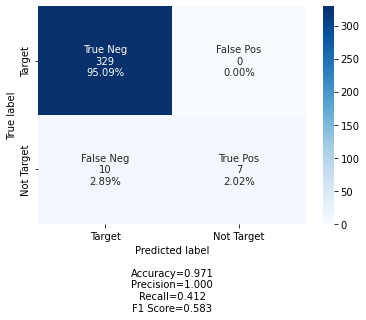

In [27]:
from cf_matrix import make_confusion_matrix

labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Target", "Not Target"]
make_confusion_matrix(result, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [28]:
#TODO get and possibly plot distances
#TODO apply gridsearch?
#TODO make probabilities more interpretable
#TODO make eval function.. better
#TODO add more EDA graphs for groupings and variable comparisons (stats)
#TODO can this be self-tuning w/gridsearch?

#TODO ### 1.5 Observations
#TODO chi square!
#TODO explain confusion matrix and scores.
#TODO Make banner out of KNN results


In [29]:
# DENOTES
# May.4
# something interesting that just happened is that I realized, a little latr, that using car_class would have created a multilabel problem.
    # I found this, might be worth looking into later. http://scikit.ml/api/skmultilearn.adapt.mlknn.html
    # For now, the problem has (thankfully) evolved into a simpler direction where I compose a target, based on what features I might wat to see in a car.
